## General Quantiative Framework for interest rate model parameterisation in (LLamma) Lend Markets

### Background 
Before we begin let's understand how one can define what constitutes an optimal Utilization, $U_{optimal}$, in a lending market. [Goldmann et al., (2023)](https://chaoslabs.xyz/resources/chaos_labs_v0_quantitative_interest_rate_parameter_framework.pdf), a.k.a. our friends at Chaos Labs provide a good foundation. [Gauntlet (2022)](https://www.gauntlet.xyz/resources/interest-rate-curve-optimization) also provide some hint on how one may approach this, yet less detialed. 

The core problem revolves around determining the "optimal utilization" of a lending protocol, balancing the interests of borrowers, suppliers, and the protocol itself. While borrowers aim for lower borrowing rates and suppliers for higher returns, minimizing the spread between these rates maximizes collective welfare. 

Intuitively, maximizing utilization would increase capital efficiency and seem optimal. However, at 100% utilization, several issues arise:

1. **Liquidation Risks:** Liquidators can't access underlying tokens to cover underwater positions, as only illiquid representations (e.g., aTokens) are available, exposing them to inventory risk until utilization drops.
   
2. **Supplier Accessibility:** At full utilization, suppliers can't withdraw funds, leading to poor user experience and decreased protocol reliability.

Thus, optimal utilization isn't about maximizing efficiency alone but finding the highest safe utilization level where the protocol can still support liquidations and withdrawals effectively. Non-utilized supply acts as risk capital, safeguarding the protocol against operational and liquidity risks.

### **Setting $U_{optimal}$, a.k.a., the target Utilisation**
We will outline two simple approaches to full-fill the goal to set $U_{optimal}$: 
- The first is simplely to estimated a buffer of liquidity that needs to be idle to meet operational liquidity needs
- The second approach estimated a buffer of liquidity that needs, while maximising borrower and supplier utility. 

> Note: In case of LlammaLend we do not work with aToken, this eliminates inventory risk, meaning IRM does not have to support Liquidations Risk.

#### Approach 1: Minimum Withdrawal Buffer
This approach focuses exclusively on maintaining enough unutilized liquidity to support supplier withdrawals and hence ensure minimal operational liquidity needs.

**Peak Withdrawal Activity $ W $:**
   - The highest historical or estimated withdrawal demand during volatile or stress periods.
   - Represents the liquidity suppliers need to withdraw without disruption.


**Formula for $U_{opt}$**
$$
U_{opt} = 1 - W,
$$
where $ W $ is expressed as a percentage of total liquidity.


**Practical Example**
Suppose:
- $W = 5\%$ (withdrawal activity during peak market volatility).

$$
U_{opt} = 1 - W = 1 - 0.05 = 0.95 \, \text{(95 \%)}
$$

This means the protocol can allow up to 95% utilization while keeping enough liquidity for supplier withdrawals.

In [2]:
W = 0.15
u_optimal = 1 - W

print(f"Optimal Utilisation: {u_optimal*100} %")

Optimal Utilisation: 85.0 %


#### Approach 2:
This approach optimizes the utilization ratio $ U_{opt} $ by balancing borrower and supplier utilities while ensuring sufficient liquidity for withdrawals.

**1. Core Objective**
Maximize the protocol's total utility $U_p$:

$$
U_p = \alpha \cdot U_b + \beta \cdot U_s
$$

Where:
- **Borrower Utility $U_b$**:
  $$
  U_b = -r_b \cdot D
  $$
  Borrowers prefer lower borrowing rates $ r_b $.
- **Supplier Utility $ U_s $**:
  $$
  U_s = r_s \cdot S - \lambda \cdot W
  $$
  Suppliers prefer higher supply rates $r_s$and penalize unmet liquidity $W$.

**2. Interest Rate Model**
The borrow rate $ r_b $ and supply rate $r_s $ are determined by the chosen interest rate model. For a semi-log model:
$$
r_b(u) = a + b \cdot \log(u) \quad \text{if } u > 0,
$$
$$
r_s(u) = r_b(u) \cdot u
$$
Where $ a, b $ are constants, and $ u = \frac{D}{S} $ is the utilization ratio.

**3. Constraints**
1. **Liquidity Constraint**:
   $$
   W = S \cdot (1 - u) \geq W_{\text{min}}
   $$
   Ensure sufficient liquidity (\( W \)) for withdrawals (see prior method for parameterisation).

2. **Optimize $ U_p $**:
   Find $ u $ or $U_{opt} $ that maximizes $U_p $, subject to the liquidity constraint.

---

### **Implementation Steps**
1. **Define Inputs**:
   - Historical or estimated values for $ S, W_{\text{min}}, \lambda, \alpha, \beta, a, b $.

2. **Calculate Utilities**:
   - Borrower utility $ U_b $: Compute based on $ r_b(u) $.
   - Supplier utility $ U_s $: Derive from $r_s(u) $ and penalty for unmet liquidity.

3. **Protocol Utility $ U_p $**:
   Combine $ U_b $ and $ U_s $ with weights $ \alpha, \beta $.
   > Note: we can adjust weight to make it more borrower/ supplier centric

4. **Optimize**:
   Use numerical methods (e.g., gradient descent, grid search) to find $ U_{opt} $ that maximizes $ U_p $, ensuring $ W \geq W_{\text{min}} $.

In [3]:
# dummy implementation 
import numpy as np
from scipy.optimize import minimize

# Define the semi-log interest rate model
def semi_log(U, a, b):
    return a + b * np.log(U) if U > 0 else np.inf

# Define the utility functions
def borrower_utility(U, a, b, S):
    r_b = semi_log(U, a, b)
    return -r_b * U * S

def supplier_utility(U, a, b, S, lambda_):
    r_b = semi_log(U, a, b)
    r_s = r_b * U
    W = S * (1 - U)  # unutilized liquidity
    return r_s * S - lambda_ * W

def protocol_utility(U, a, b, S, lambda_, alpha, beta):
    U_b = borrower_utility(U, a, b, S)
    U_s = supplier_utility(U, a, b, S, lambda_)
    return -(alpha * U_b + beta * U_s)  # Negative for minimization

# Parameters
a = 0.02  # base rate
b = 0.05  # log scaling factor
S = 1_000_000  # total supply
lambda_ = 0.05 # penalty for unmet liquidity
alpha = 1  # borrower utility weight
beta = 1  # supplier utility weight
W_min = 0.1 * S  # minimum withdrawal liquidity

# Constraint: W >= W_min -> U <= 1 - W_min / S
constraints = {'type': 'ineq', 'fun': lambda U: 1 - W_min / S - U}

# Bounds: U must be between 0 and 1
bounds = [(0.01, 0.99)]

# Optimize to find U_optimal
result = minimize(
    protocol_utility, 
    x0=[0.5],  # Initial guess for U
    args=(a, b, S, lambda_, alpha, beta), 
    constraints=constraints, 
    bounds=bounds, 
    method='SLSQP'
)

# Extract optimal utilization
U_optimal = result.x[0]
U_optimal


0.8813039780288818

### **General Interest Rate Parameterisation Methodology**
This methodology models the dynamics of **utilization ratios** $U_t$ in a financial system using stochastic processes and evaluates different **interest rate models** to optimize their parameters. The goal is to find parameters for each model that minimize the deviation of the utilization ratio from a **target utilization** $U_{\text{target}}$. It is based on [Bertucci et al. 2024](https://papers.ssrn.com/sol3/Delivery.cfm/SSRN_ID4802776_code2149929.pdf?abstractid=4802776&mirid=1) and slightly adapted. 

---

1. **Stochastic Dynamics of Utilization**:
   - The utilization ratio evolves over time based on:
     - **Drift**: Represents deterministic forces affecting borrowing and lending.
     - **Volatility**: Captures random market fluctuations using Brownian motion.
   - Dynamics are expressed as:
     $$
     dU_t = \text{drift}(U_t, r_t) \cdot dt + \text{volatility}(U_t, r_t) \cdot dW_t
     $$
     where $ r_t $ is the interest rate determined by the model.

2. **Interest Rate Models**:
   - Various models (e.g., Semi-log MP, Linear, Exponential) define $ r(U) $, the interest rate as a function of utilization.
   - Each model has parameters (e.g., $ a, b, c $) that control its behavior.

3. **Simulation of Dynamics**:
   - The stochastic dynamics of $ U_t $ are simulated over a time horizon $T $ using the specified interest rate model.
   - The simulation outputs a **utilization path**.

4. **Loss Function**:
   - The loss function measures the average squared deviation of $U_t$ from $U_{\text{target}}$:
     $$
     \text{Loss} = \frac{1}{T} \int_0^T (U_t - U_{\text{target}})^2 \, dt
     $$
   - This quantifies how well the model maintains utilization near the target.

5. **Optimization**:
   - The parameters of each interest rate model are optimized to minimize the loss function.
   - Techniques:
     - **Grid Search**: Tests combinations of parameter values to find the minimum loss.
     - **Multiple Runs**: Averages the loss over multiple simulations to reduce variability.

---

### **Steps in the Optimization Process**

1. **Define the Models**:
   - Specify the mathematical form of each interest rate model and its parameter grid.

2. **Simulate Utilization Dynamics**:
   - For each parameter combination:
     - Simulate the stochastic evolution of $ U_t $ using the interest rate model.
     - Record the utilization path.

3. **Evaluate Loss**:
   - Calculate the loss for each parameter combination by comparing the utilization path to $ U_{\text{target}} $.

4. **Find Optimal Parameters**:
   - Identify the parameter combination that minimizes the average loss over multiple runs.

5. **Compare Models**:
   - Use the optimal loss values and parameter sets to compare the performance of different models.

---

### **How It Is Used for Optimization**

- **Objective**:
  - To determine the best interest rate model and its parameters for maintaining market utilization near a desired level.

- **Process**:
  1. **Setup**:
     - Define a target utilization $ U_{\text{target}} $, simulation time $ T $, and system parameters (e.g., $A, C, \sigma_{\text{const}} $).
  2. **Optimization**:
     - For each model:
       - Run simulations for different parameter sets.
       - Calculate the average loss over multiple runs to account for randomness.
       - Identify the parameter set with the lowest loss.
  3. **Model Comparison**:
     - Compare models based on their minimum loss values and utilization paths.

- **Outcome**:
  - The methodology provides:
    - Optimal parameters for each interest rate model.
    - Insights into how different models perform in controlling utilization.

---

### **Advantages**
- Handles randomness in market dynamics through stochastic simulation.
- Provides a quantitative framework for comparing interest rate models.
- Reduces risk of instability by optimizing for target utilization.

### **Limitations**
- Computationally intensive due to multiple simulations and parameter grids.
- Assumes the target utilization and system parameters are well-defined and constant.

----


Step 1: Define Utilization Dynamics
- The drift term describes the deterministic evolution of utilization based on borrower and lender sensitivities. 
- The volatility term captures random market fluctuations.

In [17]:
import numpy as np

def drift(U, r, A, C, r0, r1):
    """
    Compute the drift term for utilization dynamics.
    
    Parameters:
        U (float): Current utilization ratio.
        r (float): Current interest rate.
        A (float): Borrower sensitivity.
        C (float): Lender sensitivity.
        r0 (float): Borrower alternative rate.
        r1 (float): Lender alternative rate.
    
    Returns:
        float: Drift value for utilization.

    This corresponds to the deterministic part of the dynamics in Eq. (30) of the paper,
    where borrower behavior (B') and lender behavior (S') are modeled as proportional
    to (r0 - r) and (U*r - r1), respectively. These terms simplify the SDE from Eq. (5).

    """
    return A * U * (r0 - r) - C * (1 - U) * (r - r1)

def volatility(U, sigma_const):
    """
    Compute the volatility term for utilization dynamics.
    
    Parameters:
        U (float): Current utilization ratio.
        sigma_const (float): Volatility constant.
    
    Returns:
        float: Volatility value for utilization.

    Refers to the stochastic term in Eq. (5), with sigma_const modeling the uncertainty in 
    utilization dynamics due to random external shocks, as discussed in Sec. 3.1.
    """
    return sigma_const * U


Step 2: Define the Interest Rate Models
- Models $𝑟(𝑈)$ the interest rate as a function of utilization.
- Semi-log MP is chosen for its smooth rate adjustments at varying utilizations.

In [ ]:
# --- Interest Rate Models ---
def semi_log_mp(U, r_base, a):
    """
    Semi-log MP Interest Rate Model.

    Parameters:
    - U (float or np.array): Utilization ratio (0 <= U < 1).
    - r_base (float): Base interest rate.
    - a (float): Scaling factor for the semi-logarithmic term.

    Returns:
    - r (float or np.array): Interest rate corresponding to utilization ratio.
    """
    # Ensure stability by clipping U close to 1
    epsilon = 1e-6
    U_clipped = min(U, 1 - epsilon)  # Ensure U is strictly less than 1
    return r_base + a * np.log(1 / (1 - U_clipped))

def linear_model(U, a, b):
    return a + b * U

def piecewise_linear_model(U, a, b1, b2, U_threshold):
    return a + b1 * U if U <= U_threshold else a + b1 * U_threshold + b2 * (U - U_threshold)

def secondary_market_model(U, a, b):
    return a + b / (1 - U) if U < 1 else np.inf

def quadratic_model(U, a, b, c):
    return a + b * U + c * U**2

def exponential_model(U, a, b):
    return a * np.exp(b * U)

def cubic_model(U, a, b, c, d):
    return a + b * U + c * U**2 + d * U**3


models = {
    "Semi-log MP": (semi_log, [np.linspace(0.01, 0.1, 10), np.linspace(0.1, 1.0, 10)]),
    "Linear": (linear_model, [np.linspace(0.01, 0.1, 10), np.linspace(0.1, 1.0, 10)]),
    "Piecewise Linear": (piecewise_linear_model, [
        np.linspace(0.01, 0.1, 5),  # a
        np.linspace(0.1, 1.0, 5),  # b1
        np.linspace(0.5, 1.5, 5),  # b2
        np.linspace(0.3, 0.7, 5)   # U_threshold
    ]),
    "Secondary Market": (secondary_market_model, [np.linspace(0.01, 0.1, 10), np.linspace(0.1, 1.0, 10)]),
    "Quadratic": (quadratic_model, [
        np.linspace(0.01, 0.1, 5),  # a
        np.linspace(0.1, 1.0, 5),  # b
        np.linspace(0.01, 0.5, 5)  # c
    ]),
    "Exponential": (exponential_model, [np.linspace(0.01, 0.1, 5), np.linspace(0.1, 1.0, 5)]),
    "Cubic": (cubic_model, [
        np.linspace(0.01, 0.1, 5),  # a
        np.linspace(0.1, 1.0, 5),  # b
        np.linspace(0.01, 0.5, 5),  # c
        np.linspace(0.01, 0.5, 5)   # d
    ])
}

Step 3: Simulate Utilization Dynamics
- Simulates the stochastic evolution of $𝑈_𝑡$ using the drift and volatility terms.
- Ensures $U_t$ remains within the valid range [0, 1].

In [18]:
def simulate_utilization(U0, T, dt, rate_model, A, C, r0, r1, sigma_const, params):
    """
    Simulate utilization dynamics using a stochastic differential equation.
    
    Parameters:
        U0 (float): Initial utilization ratio.
        T (float): Total simulation time.
        dt (float): Time step.
        rate_model (function): Interest rate model function.
        A (float): Borrower sensitivity.
        C (float): Lender sensitivity.
        r0 (float): Borrower alternative rate.
        r1 (float): Lender alternative rate.
        sigma_const (float): Volatility constant.
        params (list): Parameters for the rate model.
    
    Returns:
        np.array: Utilization path over time.

    This function generates paths to validate the SDE's performance and the resulting interest
    rate curves, similar to the numerical validation described in Sec. 6 of the paper.
    """
    n_steps = int(T / dt)
    U = U0
    path = [U0]

    for _ in range(n_steps):
        dW = np.random.normal(0, np.sqrt(dt))  # Brownian motion increment
        r = rate_model(U, *params)  # Compute interest rate using the model
        dU = drift(U, r, A, C, r0, r1) * dt + volatility(U, r, sigma_const) * dW
        U = max(0, min(1, U + dU))  # Keep U in the range [0, 1]
        path.append(U)
    return np.array(path)


Step 4: Define the Reward Function
- Balances revenue $r(U)$ against penalties for deviating from $U_{target}$



In [7]:
def reward_function(U, r, U_target, lambda_penalty):
    """
    Reward function for optimization.
    U: Utilization ratio.
    r: Interest rate.
    U_target: Target utilization (can be dynamically set).
    lambda_penalty: Penalty weight for deviation from U_target.

    Based on the stationary problem form in Eq. (4) and the HJB formulation in Sec. 3.1.3,
    where the optimal control is derived using dynamic programming principles.
    """
    revenue = r * U
    penalty = lambda_penalty * (U - U_target)**2
    return revenue - penalty

Step 5: Simulates Utilisation path
- Parameterises the interest rate model against n simulated utilisation paths to identitfy optimal parameter across a range of setting 


In [8]:
def evaluate_path(params, U0, T, dt, rate_model, A, C, r0, r1, sigma_const, U_target, lambda_penalty):
    """
    Simulate a single path and calculate the cumulative reward for given parameters.
    """
    path = simulate_utilization(U0, T, dt, rate_model, A, C, r0, r1, sigma_const, params)
    rewards = []
    for U in path:
        r = rate_model(U, *params)
        rewards.append(reward_function(U, r, U_target, lambda_penalty))
    return -np.sum(rewards)  # Negate for minimization

Step 6: Estimate input based on empirical data

In [9]:
def estimate_parameters(data=None):
    """
    Mock parameter estimation function using test OLS output values.
    """
    # Replace with the OLS-derived coefficients from your output
    A = 7.3575341941648  # Coefficient for borrower sensitivity
    C = -1.8926182740756326e-09  # Coefficient for lender sensitivity
    sigma_const = 0.3703943233589455  # Derived volatility constant
    r0, r1 = 0.02, 0.05  # Borrower and lender alternative rates (constants)

    return A, C, r0, r1, sigma_const

Step 7: Optimisation function 

In [10]:
def optimize_path(U0, T, dt, rate_model, A, C, r0, r1, sigma_const, U_target, lambda_penalty, param_ranges):
    """
    Optimize parameters for a single simulated utilization path.
    """
    def objective(params):
        return evaluate_path(params, U0, T, dt, rate_model, A, C, r0, r1, sigma_const, U_target, lambda_penalty)
    
    # Initial guess and bounds
    initial_guess = [np.mean(r) for r in param_ranges]
    bounds = [(min(r), max(r)) for r in param_ranges]
    
    # Optimization
    result = minimize(objective, initial_guess, bounds=bounds, method="L-BFGS-B")
    return result.x, -result.fun  # Return optimal parameters and maximum reward


Step 8: Optimise Parameters across multiple runs 

In [11]:
def parameter_optimization(U0, T, dt, rate_model, A, C, r0, r1, sigma_const, U_target, lambda_penalty, param_ranges, n_repeats=30):
    """
    Perform optimization over multiple simulation paths to identify robust parameters.
    """
    optimal_parameters = []
    rewards = []
    for _ in range(n_repeats):
        # Optimize parameters for a single path
        opt_params, max_reward = optimize_path(U0, T, dt, rate_model, A, C, r0, r1, sigma_const, U_target, lambda_penalty, param_ranges)
        optimal_parameters.append(opt_params)
        rewards.append(max_reward)
    
    # Aggregate results
    mean_params = np.mean(optimal_parameters, axis=0)
    mean_reward = np.mean(rewards)
    
    return mean_params, mean_reward

Step 9: Execute experiment 

In [12]:
# Initial settings
U0 = 0.9  # Initial utilization ratio
T = 10    # Simulation time
dt = 0.01  # Time step
U_target = u_optimal  # Target utilization ratio
lambda_penalty = 1  # Penalty weight
n_repeats = 1  # Number of paths for robustness testing

# Parameter estimation
A, C, r0, r1, sigma_const = estimate_parameters(None)  # Replace None with actual data if available

# Parameter ranges for each model
model_params = {
    "Semi-log MP": [np.linspace(0.01, 0.1, 10), np.linspace(0.1, 1.0, 10)],
    "Piecewise Linear": [
        np.linspace(0.01, 0.1, 5),  # a
        np.linspace(0.1, 1.0, 5),  # b1
        np.linspace(0.5, 1.5, 5),  # b2
        [U_target]   # U_threshold
    ],
}

# Optimize and validate each model
optimize_parameters_dict = {}
for model_name, param_ranges in model_params.items():
    print(f"Optimizing {model_name} model...")
    rate_model = models[model_name][0]
    optimal_params, mean_reward = parameter_optimization(
        U0, T, dt, rate_model, A, C, r0, r1, sigma_const, U_target, lambda_penalty, param_ranges, n_repeats
    )
    optimize_parameters_dict[model_name] = optimal_params
    print(f"Robust Optimal Parameters for {model_name}: {optimal_params}")
    print(f"Mean Reward across {n_repeats} paths: {mean_reward}\n")


Optimizing Semi-log MP model...
Robust Optimal Parameters for Semi-log MP: [0.05500201 0.54997699]
Mean Reward across 1 paths: -19.897511904011857

Optimizing Piecewise Linear model...
Robust Optimal Parameters for Piecewise Linear: [0.05499999 0.5499993  0.99999946 0.85      ]
Mean Reward across 1 paths: -643.4582658215431



In [13]:
optimize_parameters_dict

{'Semi-log MP': array([0.05500201, 0.54997699]),
 'Piecewise Linear': array([0.05499999, 0.5499993 , 0.99999946, 0.85      ])}

Step 8: Validate simulated paths against utilisation and target utlisation 

In [14]:
import matplotlib.pyplot as plt 
def simulate_common_utilization_path(U0, T, dt, A, C, r0, r1, sigma_const):
    """
    Simulate a single common utilization path to be used by all models.
    """
    n_steps = int(T / dt)
    U = U0
    path = [U0]
    for _ in range(n_steps):
        dW = np.random.normal(0, np.sqrt(dt))  # Brownian motion increment
        # Use a placeholder interest rate (e.g., constant or simple model)
        r = 0.05  # Placeholder interest rate
        dU = drift(U, r, A, C, r0, r1) * dt + volatility(U, r, sigma_const) * dW
        U = max(0, min(1, U + dU))  # Ensure U stays in [0, 1]
        path.append(U)
    return np.array(path)


def simulate_interest_rates_for_path(utilization_path, rate_model, params):
    """
    Simulate interest rates for a precomputed utilization path using a specific model.
    """
    interest_rates = []
    for U in utilization_path:
        r = rate_model(U, *params)  # Interest rate based on the utilization path
        interest_rates.append(r)
    return np.array(interest_rates)


def plot_validation(U0, T, dt, models, optimal_params_dict, A, C, r0, r1, sigma_const, U_target):
    """
    Simulate utilization and interest rates for all models and plot them using a shared utilization path.
    """
    n_steps = int(T / dt)
    time = np.linspace(0, T, n_steps + 1)  # Time array includes all steps

    # Generate a single shared utilization path
    utilization_path = simulate_common_utilization_path(U0, T, dt, A, C, r0, r1, sigma_const)

    plt.figure(figsize=(12, 8))
    
    # Plot the shared utilization path
    plt.plot(time, utilization_path, linestyle="--", label="Utilization Path", color="orange")
    
    # Simulate and plot each model's interest rates
    for model_name, (rate_model, _) in models.items():
        if model_name not in optimal_params_dict:
            continue
        params = optimal_params_dict[model_name]
        interest_rates = simulate_interest_rates_for_path(utilization_path[:len(time)], rate_model, params)

        plt.plot(time, interest_rates, label=f"{model_name} Interest Rate")
    
    # Plot target utilization as a horizontal line
    plt.axhline(U_target, color="red", linestyle=":", label="Target Utilization")

    # Chart details
    plt.title("Interest Rates and Utilization Path Across Models", fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Rate/Utilization", fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()


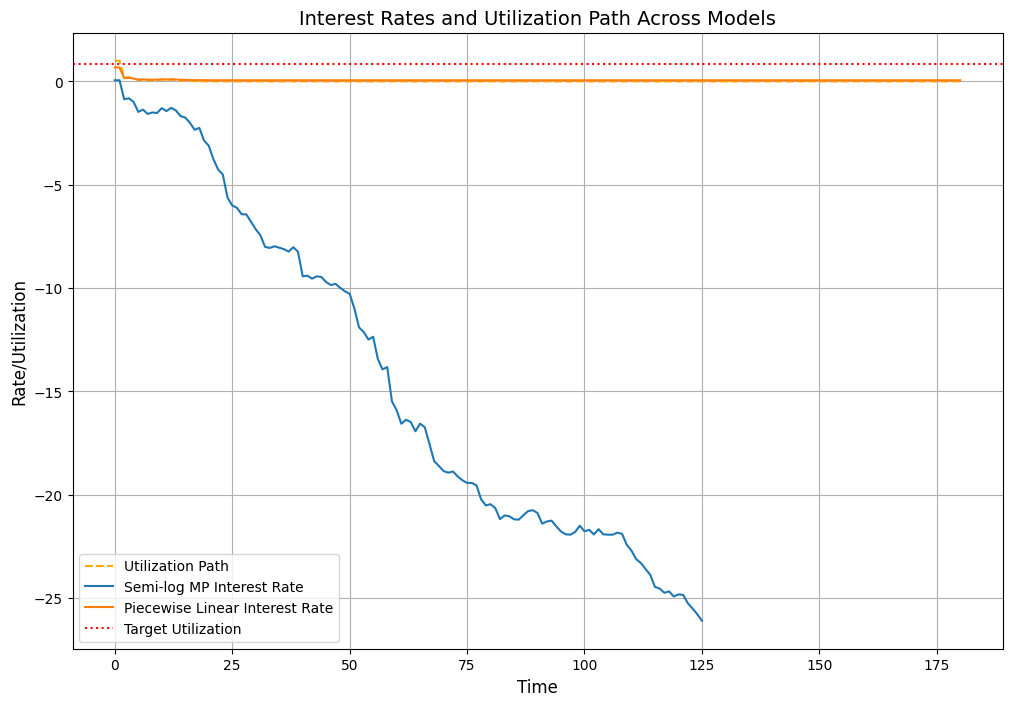

In [15]:
# Initial settings
U0 = 1  # Initial utilization ratio
T = 180   # Simulation time
dt = 1  # Time step
U_target = 0.85  # Target utilization ratio

# Parameter estimation
A, C, r0, r1, sigma_const = estimate_parameters(None)  # Replace None with actual data if available

# Plot validation results
plot_validation(U0, T, dt, models, optimize_parameters_dict, A, C, r0, r1, sigma_const, U_target)


/tmp/ipykernel_7139/306928343.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  revenue = r * U


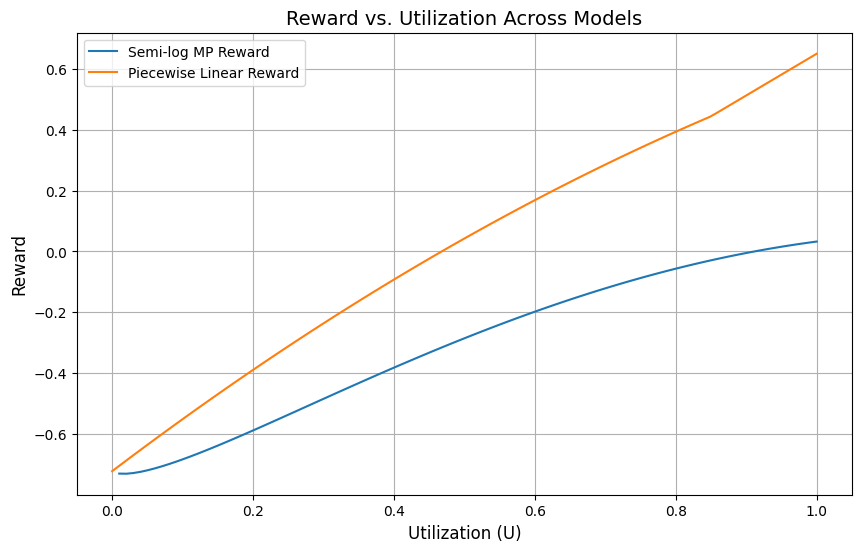

In [16]:
def plot_reward_vs_utilization(models, optimal_params_dict, U_target, lambda_penalty):
    """
    Plot reward as a function of utilization for each model.
    """
    U_range = np.linspace(0, 1, 100)  # Utilization values from 0 to 1
    plt.figure(figsize=(10, 6))
    
    for model_name, model_tuple in models.items():
        rate_model = model_tuple[0]  # Extract the callable function
        if model_name not in optimal_params_dict:
            continue
        params = optimal_params_dict[model_name]
        rewards = []
        for U in U_range:
            r = rate_model(U, *params)  # Call the function with utilization and parameters
            rewards.append(reward_function(U, r, U_target, lambda_penalty))
        plt.plot(U_range, rewards, label=f"{model_name} Reward")
    
    plt.title("Reward vs. Utilization Across Models", fontsize=14)
    plt.xlabel("Utilization (U)", fontsize=12)
    plt.ylabel("Reward", fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()


plot_reward_vs_utilization(models, optimize_parameters_dict, U_target, lambda_penalty)


### **Future R&D**

- https://arxiv.org/pdf/2407.10890